# Unsupervised Learning Case Study

----------------------------
## Objective: 
-----------------------------

Identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

--------------------------
## About the data:
--------------------------
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

- Sl_no - Customer Serial Number
- Customer Key - Customer identification
- Avg_Credit_Limit	- Average credit limit (currency is not specified, you can make an assumption around this)
- Total_Credit_Cards	- Total number of credit cards 
- Total_visits_bank	- Total bank visits
- Total_visits_online -	 Total online visits
- Total_calls_made - Total calls made

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

# clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids

# metrics 
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

### Loading data

In [2]:
df = pd.read_excel('datasets/Credit Card Customer Data.xlsx')
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Basic data info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations:**

- There are 660 observations and 7 columns in the dataset.
- All columns have 660 non-null values i.e. there are no missing values.
- All columns are of int64 data type.

## Data Preprocessing and Exploratory Data Analysis

In [4]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

**duplicated rows in Custumer Key??**

In [5]:
for col in df.columns:
    print(col+':',df[col].duplicated().sum())

Sl_No: 0
Customer Key: 5
Avg_Credit_Limit: 550
Total_Credit_Cards: 650
Total_visits_bank: 654
Total_visits_online: 644
Total_calls_made: 649


**Custumer Key cannot contain duplicated rows, so let's drop then**

In [6]:
duplicated_data = df['Customer Key'].duplicated()
df[duplicated_data]

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
332,333,47437,17000,7,3,1,0
398,399,96929,67000,6,2,2,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


In [7]:
df = df[~duplicated_data]
df.shape

(655, 7)

**Removing useless columns**

In [8]:
df.drop(['Sl_No','Customer Key'], axis=1, inplace=True)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


**After removing useless columns, let's check for duplicates again, to avoid identical customers**

In [11]:
df[df.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


In [10]:
df.duplicated().sum()

11

In [12]:
df = df[~df.duplicated()]

In [14]:
df.shape

(644, 5)

- After removing the duplicated rows and useless columns from the dataset, there are 644 unique observations and 5 columns in our data.

**summary statistics**

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,644.0,34543.478261,37428.704286,3000.0,11000.0,18000.0,48000.00,200000.0
Total_Credit_Cards,644.0,4.694099,2.175338,1.0,3.0,5.0,6.00,10.0
Total_visits_bank,644.0,2.395963,1.626964,0.0,1.0,2.0,4.00,5.0
Total_visits_online,644.0,2.624224,2.957728,0.0,1.0,2.0,4.00,15.0
Total_calls_made,644.0,3.608696,2.880025,0.0,1.0,3.0,5.25,10.0


**Observations:**

- The average credit limit has a high range as it has a minimum value of 3K and a maximum value of 200K.
- The mean of the average credit limit is approx 34.5K with a large standard deviation of 37.4K.
- The average number of cards per customer is approx 5 (rounding off to nearest integer).
- On average, a customer has 2 bank visits, 3 online visits, and made 4 calls. 

#### Now let's go ahead with the exploring each variable at hand. We will check the distribution and outliers for each variable in the data.

Avg_Credit_Limit
skew: 2.19


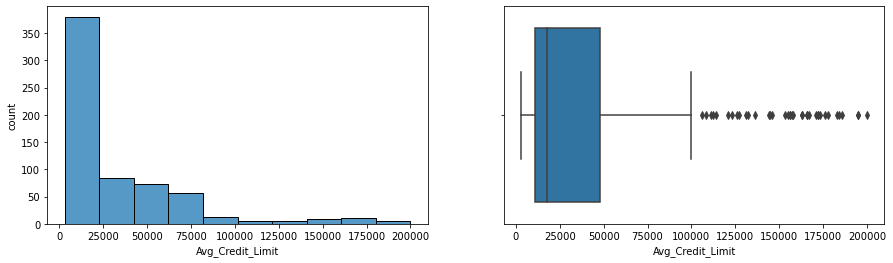

Total_Credit_Cards
skew: 0.17


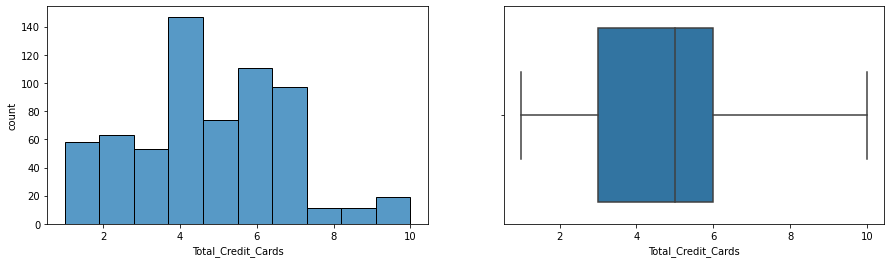

Total_visits_bank
skew: 0.15


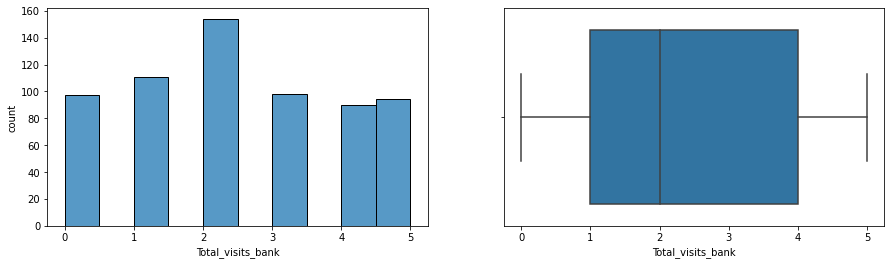

Total_visits_online
skew: 2.21


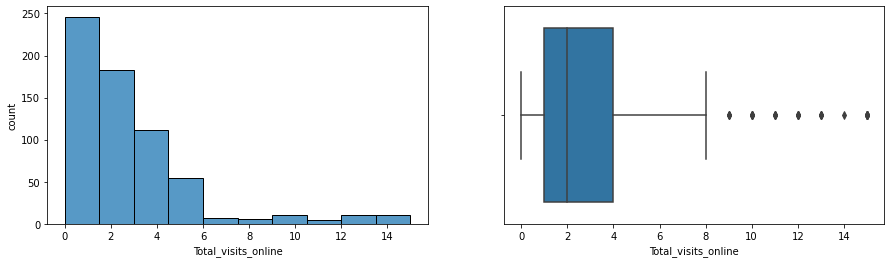

Total_calls_made
skew: 0.65


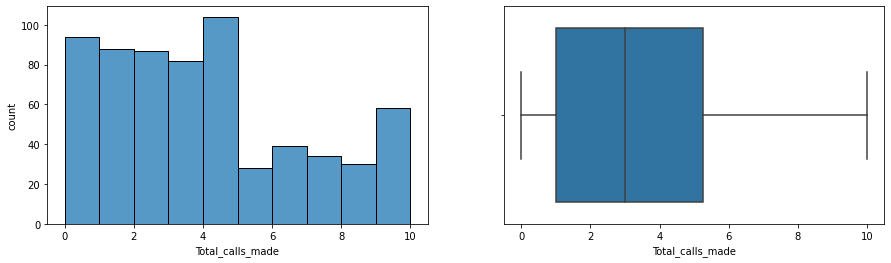

In [21]:
for col in df.columns:
    print(col)
    print(f'skew: {round(df[col].skew(), 2)}')
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    sns.histplot(x=df[col], bins=10, data=df)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col])
    plt.show()

**Observation:**

- The average credit limit and total visits online has a right skewed distribution with some outliers.
- The majority of customers have 4 credits cards, 2 bank visits, and 4 calls.

**Now, let's check the correlation among different variables.**

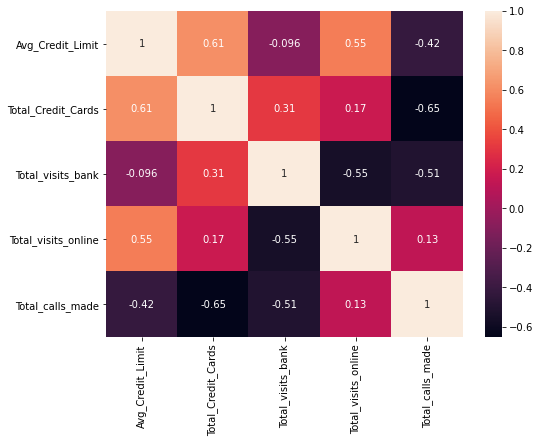

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

**Observation:**

- Avg_Credit_Limit is positively correlated with Total_Credit_Cards Total_visits_online which can makes sense.
- Avg_Credit_Limit is negatively correlated with Total_calls_made and Total_visits_bank.
- Total_visits_bank, Total_visits_online, Total_calls_made are negatively correlated which implies that majority of customers use only one of these channels to contact the bank.

**Scaling the data**

In [28]:
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.750192,-1.239437,-0.858684,-0.549573,-1.253982
1,0.413280,-0.779381,-1.473803,2.495669,1.873420
2,0.413280,1.060843,-0.858684,0.127148,0.135974
3,-0.121485,0.140731,-0.858684,-0.549573,0.135974
4,1.750192,0.600787,-1.473803,3.172390,-0.211515


In [29]:
#Creating copy of the data to store labels from each algorithm
df_scaled_copy = df_scaled.copy(deep=True)

## KMeans

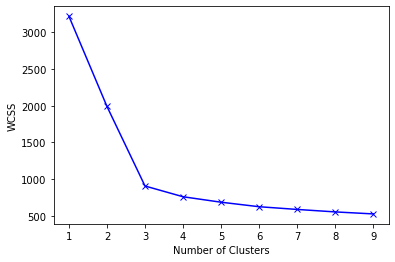

In [32]:
WCSS = {}

for k in range(1,10):
    kmodel = KMeans(n_clusters=k, max_iter=1000)
    kmodel.fit(df_scaled)
    WCSS[k] = kmodel.inertia_
    
plt.figure()
plt.plot(range(1,10), list(WCSS.values()), 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
    

**Observations:**
- Looking at the plot, we can say that elbow point is achieved for k=3.
- We will fit the k-means again with k=3 to get the labels.

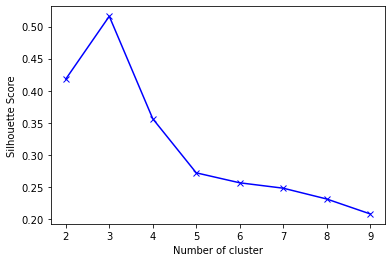

In [37]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {}

#Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2,10):
    kmodel = KMeans(n_clusters=k)
    kmodel.fit(df_scaled)
    labels = kmodel.predict(df_scaled)
    sc[k] = silhouette_score(df_scaled, labels)
    
#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

**Fitting the K-means algorithms on the scaled data with number of cluster equal to 3 and Storing the predictions as 'Labels' to the 'data_scaled_copy' and 'data' dataframes**

In [43]:
kmodel = KMeans(n_clusters=3, max_iter=1000, random_state=1)
kmodel.fit(df_scaled)

df_scaled_copy['labels'] = kmodel.predict(df_scaled)
df['labels'] = kmodel.predict(df_scaled)

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,100000,2,1,1,0,1
1,50000,3,0,10,9,0
2,50000,7,1,3,4,1
3,30000,5,1,1,4,1
4,100000,6,0,12,3,2


In [44]:
df['labels'].value_counts()

1    374
0    221
2     49
Name: labels, dtype: int64

In [45]:
#Calculating summary statistics of the original data for each label
mean = df.groupby(['labels']).mean()
median = df.groupby(['labels']).median()
df_kmeans = pd.concat([mean, median], axis=0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,33893.048128,140102.040816,12000.0,31500.0,145000.0
Total_Credit_Cards,2.411765,5.508021,8.775510,2.0,6.0,9.0
Total_visits_bank,0.945701,3.489305,0.591837,1.0,3.0,1.0
Total_visits_online,3.561086,0.975936,10.979592,4.0,1.0,11.0
Total_calls_made,6.891403,1.997326,1.102041,7.0,2.0,1.0


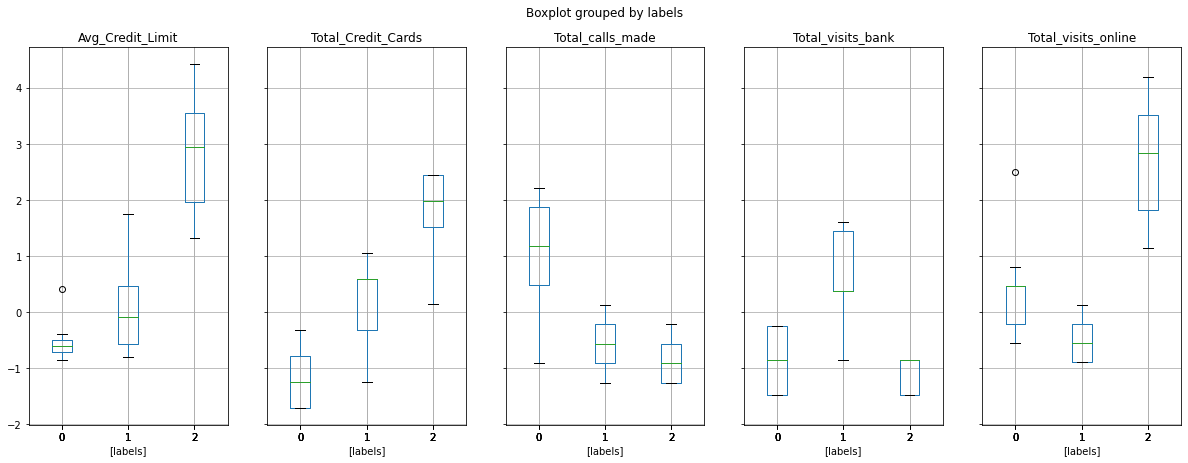

In [48]:
#Visualizing different features w.r.t K-means labels
df_scaled_copy.boxplot(by = 'labels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**
- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.
- Cluster 2 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.

# Gaussian Mixture

Let's create clusters using Gaussian Mixture Models

**Finding Optimal K using Silhouette for GMM model**

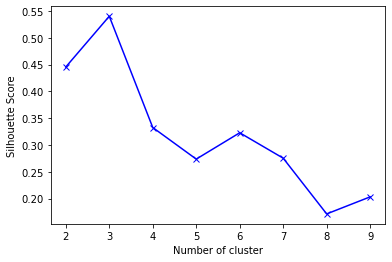

In [49]:
#Empty dictionary to store the Silhouette score for each value of k
sc = {} 

# iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that k 
for k in range(2,10):
    GMM = GaussianMixture(n_components=k)
    GMM.fit(df_scaled)
    labels = GMM.predict(df_scaled)
    sc[k] = silhouette_score(df_scaled, labels)
    
#Elbow plot
plt.figure()
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.show()

**Fitting the GMM model** 

In [50]:
GMM = GaussianMixture(n_components=3)
GMM.fit(df_scaled)

df_scaled_copy['GmmLabels'] = GMM.predict(df_scaled)
df['GmmLabels'] = GMM.predict(df_scaled)
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels,GmmLabels
0,100000,2,1,1,0,1,0
1,50000,3,0,10,9,0,1
2,50000,7,1,3,4,1,0
3,30000,5,1,1,4,1,0
4,100000,6,0,12,3,2,2


In [51]:
df.GmmLabels.value_counts()

0    374
1    221
2     49
Name: GmmLabels, dtype: int64

**Creating cluster profiles using the below summary statistics and box plots for each label and Comparing the clusters from both algorithms - K-means and Gaussian Mixture**

In [52]:
#Calculating summary statistics of the original data for each label
original_features = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]

mean = df.groupby(['GmmLabels']).mean()
median = df.groupby(['GmmLabels']).median()

df_gmm = pd.concat([mean, median], axis=0)
df_gmm.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_gmm[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,33893.048128,12239.819005,140102.040816,31500.0,12000.0,145000.0
Total_Credit_Cards,5.508021,2.411765,8.775510,6.0,2.0,9.0
Total_visits_bank,3.489305,0.945701,0.591837,3.0,1.0,1.0
Total_visits_online,0.975936,3.561086,10.979592,1.0,4.0,11.0
Total_calls_made,1.997326,6.891403,1.102041,2.0,7.0,1.0


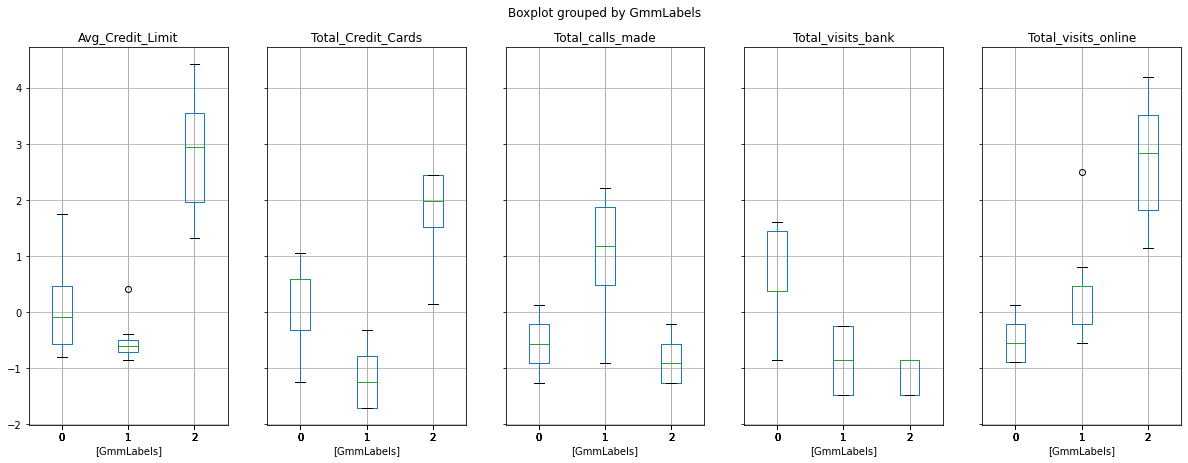

In [54]:
# plotting boxplots with the new GMM based labels

features_with_lables = ["Avg_Credit_Limit","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","GmmLabels"]

df_scaled_copy[features_with_lables].boxplot(by = 'GmmLabels', layout = (1,5),figsize=(20,7))
plt.show()

**Cluster Profiles:**

- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.
- Cluster 2 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.

**Comparing Clusters:**

- The cluster profiles are the same as the K-means clusters.

# K-Medoids

In [55]:
kmedo = KMedoids(n_clusters=3, random_state=1)
kmedo.fit(df_scaled)

df_scaled_copy['kmedoLabels'] = kmedo.predict(df_scaled)
df['kmedoLabels'] = kmedo.predict(df_scaled)

df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels,GmmLabels,kmedoLabels
0,100000,2,1,1,0,1,0,2
1,50000,3,0,10,9,0,1,0
2,50000,7,1,3,4,1,0,2
3,30000,5,1,1,4,1,0,2
4,100000,6,0,12,3,2,2,2


In [57]:
#Number of observations in each cluster
df.kmedoLabels.value_counts()

1    290
0    221
2    133
Name: kmedoLabels, dtype: int64

In [58]:
#Calculating summary statistics of the original data for each label
mean = df.groupby('kmedoLabels').mean()
median = df.groupby('kmedoLabels').median()
df_kmedoids = pd.concat([mean, median], axis=0)
df_kmedoids.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']
df_kmedoids[original_features].T

,group_0 Mean,group_1 Mean,group_2 Mean,group_0 Median,group_1 Median,group_2 Median
Avg_Credit_Limit,12239.819005,28375.862069,85052.631579,12000.0,19500.0,68000.0
Total_Credit_Cards,2.411765,5.362069,7.030075,2.0,5.0,7.0
Total_visits_bank,0.945701,3.824138,1.691729,1.0,4.0,2.0
Total_visits_online,3.561086,0.986207,4.639098,4.0,1.0,2.0
Total_calls_made,6.891403,1.858621,1.969925,7.0,2.0,2.0


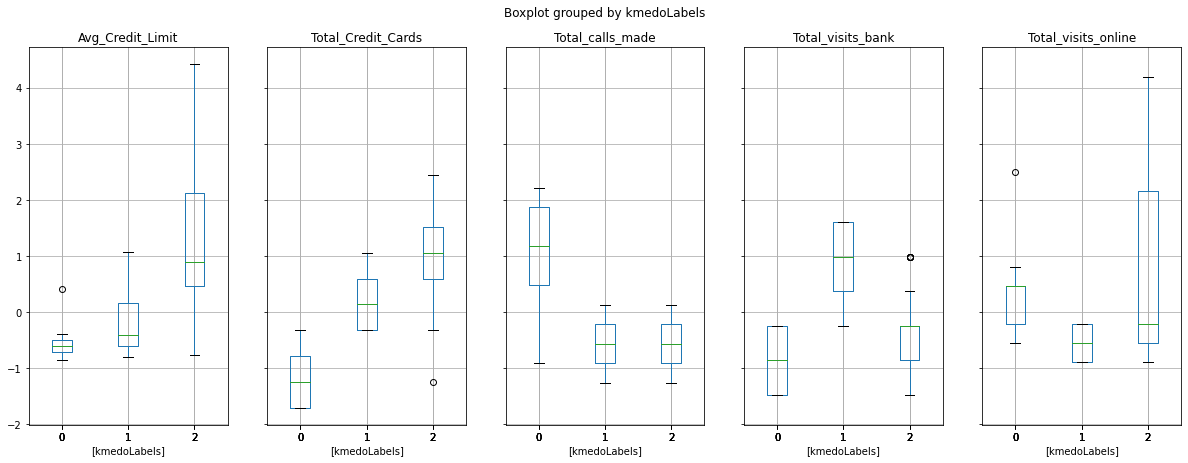

In [59]:
#plotting boxplots with the new K-Medoids based labels

features_with_lables = ["Avg_Credit_Limit",	"Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made","kmedoLabels"]

df_scaled_copy[features_with_lables].boxplot(by = 'kmedoLabels', layout = (1,5),figsize=(20,7))
plt.show()

In [60]:
comparison = pd.concat([df_kmedoids, df_kmeans], axis=1)[original_features]
comparison

,Avg_Credit_Limit,Avg_Credit_Limit,Total_Credit_Cards,Total_Credit_Cards,Total_visits_bank,Total_visits_bank,Total_visits_online,Total_visits_online,Total_calls_made,Total_calls_made
group_0 Mean,12239.819005,12239.819005,2.411765,2.411765,0.945701,0.945701,3.561086,3.561086,6.891403,6.891403
group_1 Mean,28375.862069,33893.048128,5.362069,5.508021,3.824138,3.489305,0.986207,0.975936,1.858621,1.997326
group_2 Mean,85052.631579,140102.040816,7.030075,8.775510,1.691729,0.591837,4.639098,10.979592,1.969925,1.102041
group_0 Median,12000.000000,12000.000000,2.000000,2.000000,1.000000,1.000000,4.000000,4.000000,7.000000,7.000000
group_1 Median,19500.000000,31500.000000,5.000000,6.000000,4.000000,3.000000,1.000000,1.000000,2.000000,2.000000
group_2 Median,68000.000000,145000.000000,7.000000,9.000000,2.000000,1.000000,2.000000,11.000000,2.000000,1.000000


**Cluster Profiles:**
- Cluster 0 - Low Credit Cutsomers: This cluster represents customers with low spending and prefers to interact with the bank via calls and therefore they have less number of bank and online visits.
- Cluster 1 - High Credit Customers: This cluster represents customers with high spending and prefers to contact the bank through online channel and therefore they have less number of total calls and bank visits.
- Cluster 2 - Medium Credit Customers: This cluster represents customers who spends comparatively more than low credit customers and visits the bank more often and therefore they have less number of calls and online visits.

**Comparing Clusters:**

- The size of clusters (count of observations) from K-Medoids is different from K-means clusters. In K-Medoids, number of observations are evenly distributed among clusters. 
- K-Medoids clusters are more compact i.e. have small ranges for all variables. For example, the range of total number of credit cards is from 4 to 7 for medium credit customers from K-Medoids, whereas from K-Means, it is from 2 to 7.
- K-Medoids is more robust to outliers which helps to identify outliers in the clusters. For example, the total number of bank visits has an outlier for high credit customers from K-Medoids, whereas from K-Means, we could not detect any outliers in this variable.